# --Step 1. Import libraries and data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ppscore as pps

# models
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,  VotingRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor
# Pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import TransformerMixin
# Tools
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel,SelectKBest, chi2
import time


# options
pd.set_option('display.max_columns', None)
warnings.filterwarnings(action = "ignore")
%matplotlib inline

In [3]:
# trainning df
train_df = pd.read_csv(r'Ames_data\train.csv') 
display(train_df.head(2))

# testing df
test_df = pd.read_csv(r'Ames_data\test.csv')

# full df
df = pd.concat([train_df,test_df])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


# --Step 2. EDA

### Basic overview

In [4]:
display(df.describe())
display(df.describe(include=['O']))

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,2915,2919,198,2919,2919,2917,2919,2919,2919,2919,2919,2919,2919,2919,2919,2918,2918,2895,2919,2919,2919,2838,2837,2837,2840,2839,2919,2919,2919,2918,2918,2917,1499,2762,2760,2760,2760,2919,10,571,105,2918,2919
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,2265,2907,120,1859,2622,2916,2133,2778,443,2511,2889,2425,1471,2310,2876,1025,1014,1742,1798,2538,1308,1283,2606,1904,851,2493,2874,1493,2723,2671,1492,2717,744,1723,1230,2604,2654,2641,4,329,95,2525,2402


### It's important to understand the distribution of the target variable.

If Skewness > 1, the variable is highly skewed.

If Kurtosis > 3, the variable has a heavier tail than normal distribution.

https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics

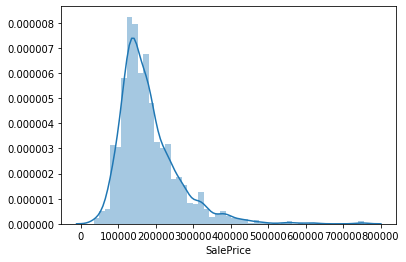

Skewness:  1.8828757597682129
Kurtosis:  6.536281860064529


In [5]:
# Show hist
sns.distplot(train_df['SalePrice'])
plt.show()

# Show stat
print('Skewness: ', train_df['SalePrice'].skew()) 
print('Kurtosis: ', train_df['SalePrice'].kurt())

### Pairwise plots

We can see that there are two points in the 'GrLivArea' vs. 'SalePrice' plot that don't follow the trend, we may create a filter to get rid of that outlier.

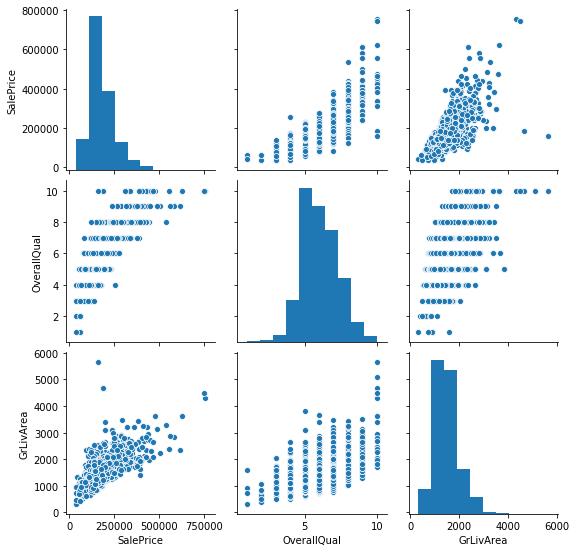

In [6]:
# selected several variables for further investigation
sns.pairplot(df[['SalePrice','OverallQual','GrLivArea']]) 
plt.show()

In [7]:
train_df[['Id','GrLivArea', 'SalePrice']].sort_values(by = 'GrLivArea', ascending = False).head(5)
train_df = train_df.drop([1298,523]) # These two were the outliers

### Feature Selection

Removing irrelevant features -> better model, easier to understand, and faster to train

1. Drop variables with too many missing values

2. Drop variables with too little variance

3. Drop variables that are highly correlated

4. Drop variables that have very low correlation with the target. (This one is tricky since we need to account for interaction effects)(But it's impossible to try every combination of paired-predictors)

5. Use LASSO / Tree (we can use PPS -> default algo is decision tree)

In [8]:
# We will the variables with >20% missing values
# PoolQC, MiscFeature, Alley, Fence to be removed

null_series = df.isnull().sum()/len(df)
null_series[null_series>0].sort_values(ascending = False)

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
SalePrice       0.499829
FireplaceQu     0.486468
LotFrontage     0.166495
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageQual      0.054471
GarageCond      0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Functional      0.000685
Utilities       0.000685
BsmtFinSF2      0.000343
BsmtUnfSF       0.000343
BsmtFinSF1      0.000343
TotalBsmtSF     0.000343
SaleType        0.000343
KitchenQual     0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
GarageCars      0.000343
GarageArea      0.000343
Electrical      0.000343
dtype: float64

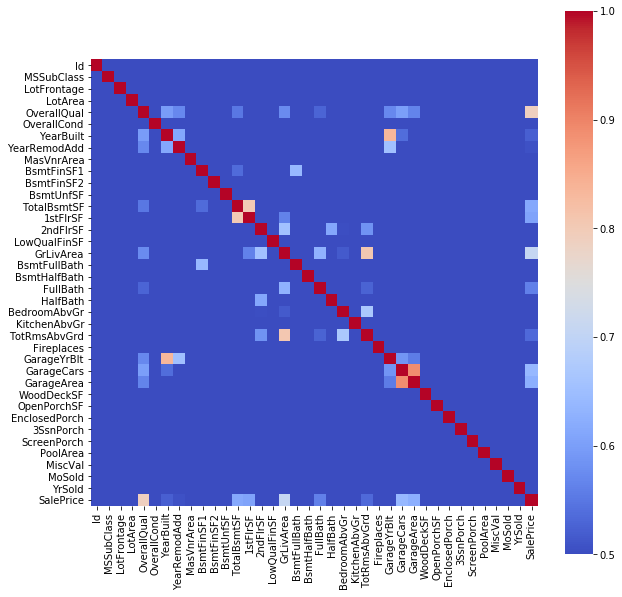

High Correlations:


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

Low Correlations:


KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
Name: SalePrice, dtype: float64

In [9]:
# show plot
# dropping variables with very low correlations to target variable
corr = df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, vmin = 0.5, square = True, cmap = 'coolwarm') 
plt.show()

# show the correlations
high_corr = corr.nlargest(10,'SalePrice')['SalePrice']
print('High Correlations:')
display(high_corr)

low_corr = corr.nsmallest(20,'SalePrice')['SalePrice']
print('Low Correlations:')
display(low_corr)

In [10]:
# Variables that we want to drop
drop_variables = ['YrSold', 'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', '3SsnPorch', 'MoSold',
                  'SalePrice','Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu']

# --Step 3. Building a Pipeline

### Preprocessing step

In [11]:
x = train_df.drop(['SalePrice'], axis = 1)
y = train_df['SalePrice']

# split into train & test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 78)

In [12]:
#Define lists of interest
categorical_features = [i for i in train_df.columns if (train_df[i].dtype == 'object') and i not in drop_variables]
numerical_features = [i for i in train_df.columns if (train_df[i].dtype in ['int32','int64','float32','float64']) and
           i not in drop_variables]

#Define imputers
imp_freq = SimpleImputer(strategy = 'most_frequent')
imp_med = SimpleImputer(strategy = 'median')
KNN_imputer = KNNImputer(n_neighbors = 2)

In [13]:
# Impute
#cat pipeline
cat_pipeline = Pipeline(steps =[
                        ('imp_cat', imp_freq),
                        ('OHE', OneHotEncoder(handle_unknown = 'ignore')),
                        ])

#num pipeline
num_pipeline = Pipeline(steps = [
                        ('imp_num',KNN_imputer),
                        ('std_scale', StandardScaler())
                        ])



#full preprocessing pipeline
preprocess = make_column_transformer(
    (num_pipeline,numerical_features),
    (cat_pipeline,categorical_features)
    
)

### Bench marks
Let's review the variation in SalesPrice. This should give us a good sense of benchmark to beat

In [14]:
train_df['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Model step

In [46]:
#Lasso hyperparameters
lasso = Lasso()
L_parameters = {'alpha': [ 0.001, 0.1,
                        1,10,100]}
lasso_regressor = GridSearchCV(lasso, L_parameters, scoring = 'neg_mean_squared_error', cv=5)


#Ridge
ridge = Ridge()
R_parameters = {'alpha': [ 1e-10, 1e-5,
                        1e-4,1e-3, 1e-2,
                        1,10,100,1000]}
ridge_regressor = GridSearchCV(ridge, R_parameters, scoring = 'neg_mean_squared_error', cv=5)

#XG-Boost
xgboost = XGBRegressor()
XG_parameters = {
                'max_depth' : range(3,15,2),
                'min_child_weight' : range(1,6,1)
                }
xg_regressor = GridSearchCV(xgboost, XG_parameters, scoring = 'neg_mean_squared_error', cv=5)

In [55]:
# Deinfe model list
models = [LinearRegression(),ridge_regressor, lasso_regressor, xg_regressor]
base_MAE = 10000000

# Define steps and full pipeline
for model in models:
    steps = [('preprocess', preprocess),('Model',model)]
    pipeline = Pipeline(steps)

    # cross validate
    score = cross_validate(pipeline, x, y, cv = 5, scoring = 'neg_mean_absolute_error', return_train_score = True)
    print('\n\nModel Fitting Completed')

    # Evaluate
    train_MAE = (-1*score['train_score']).mean()
    test_MAE = (-1*score['test_score']).mean()
    print(str(model))
    print('train score : {}, test score: {}'.format(train_MAE, test_MAE))
    
    # Best pipeline
    if test_MAE < base_MAE:
        base_MAE = test_MAE
        best_pipeline = pipeline



Model Fitting Completed
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
train score : 12973.159794470626, test score: 17206.40122165191


Model Fitting Completed
GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-10, 1e-05, 0.0001, 0.001, 0.01, 1, 10,
                                   100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)
train score : 13681.099539078929, test score: 15938.272446763489


Model Fitting Completed
GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=Fa

# -----------------------------

**With average houses costing 180k, our MAE is about 16k. I would say this regression model is fairly useful in estimating the housing market.**

In [56]:
best_pipeline

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('imp_num',
                                                                   KNNImputer(add_indicator=False,
                                                                              copy=True,
                                                                              metric='nan_euclidean',
                                                                              missing_values=nan,
                                                                              n_neighbors=2,
                                                                    

In [57]:
new_x = test_df
best_pipeline.fit(x,y) #pipeline was never fit, it was passed through cross_validate
y_pred = best_pipeline.predict(new_x)

In [59]:
submission = pd.concat([test_df['Id'],pd.Series(y_pred)],axis=1)
submission.columns = ['Id','SalePrice']
submission.head(3)

,Id,SalePrice
0,1461,115415.103001
1,1462,162534.801770
2,1463,185844.198203


In [60]:
submission.to_csv('wong_submission.csv', index = False)

Resources:
    
https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

https://www.youtube.com/watch?v=YaKMeAlHgqQ